Test example: 0/30| Predicted: 1| Actual: 2| Match: False
Test example: 5/30| Predicted: 1| Actual: 2| Match: False
Test example: 10/30| Predicted: 0| Actual: 0| Match: True
Test example: 15/30| Predicted: 2| Actual: 2| Match: True
Test example: 20/30| Predicted: 2| Actual: 2| Match: True
Test example: 25/30| Predicted: 1| Actual: 1| Match: True
18 matches out of 30 examples
Test set accuracy: 60.00%


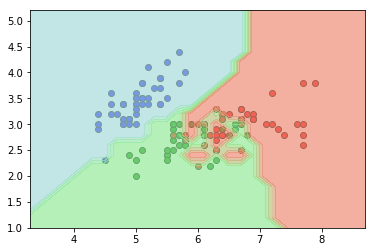

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


%matplotlib inline

class KNN:
  
  def __init__(self, nb_features, nb_classes, data, k):
    self.nb_features = nb_features
    self.nb_classes = nb_classes
    self.data = data
    self.k = k
    
    # X je feature matrica, a Q je upit.
    self.X = tf.placeholder(shape=(None, nb_features), dtype=tf.float32)
    self.Y = tf.placeholder(shape=(None), dtype=tf.int32)
    self.Q = tf.placeholder(shape=(nb_features), dtype=tf.float32)
    
    # Racunamo kvadriranu euklidsku udaljenost i uzimamo minimalnih k.
    dists = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(self.X, self.Q)), axis=1))
    _, idxs = tf.nn.top_k(-dists, self.k)  
    
    self.classes = tf.gather(self.Y, idxs)
    self.dists = tf.gather(dists, idxs)
    
    self.w = tf.fill([k], 1/k)
    
    # Svaki red mnozimo svojim glasom i sabiramo glasove po kolonama.
    w_col = tf.reshape(self.w, (k, 1))
    self.classes_one_hot = tf.one_hot(self.classes, nb_classes)
    self.scores = tf.reduce_sum(w_col * self.classes_one_hot, axis=0)
    
    # Klasa sa najvise glasova je hipoteza.
    self.hyp = tf.argmax(self.scores)
    
    # Crtamo podatke.
    idxs0 = data['y'] == '0'
    idxs1 = data['y'] == '1'
    idxs2 = data['y'] == '2'

    plt.scatter(data['x'][idxs0, 0], data['x'][idxs0, 1], c='b', 
              edgecolors='k', label='Iris-setosa')
    plt.scatter(data['x'][idxs1, 0], data['x'][idxs1, 1], c='g', 
              edgecolors='k', label='Iris-versicolor')
    plt.scatter(data['x'][idxs2, 0], data['x'][idxs2, 1], c='r', 
              edgecolors='k', label='Iris-virginica')
    
  # Za svaki x iz query_data računamo hipotezu, poredimo je sa pravom vrednošću
  # Na svakih 10 iteracija ispisujemo predviđenu i stvarnu vrednost
  def predict(self, query_data):
    
    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())
     
      nb_queries = 30
      
      matches = 0
      for i in range(nb_queries):
        hyp_val = sess.run(self.hyp, feed_dict = {self.X: self.data['x'], 
                                                  self.Y: self.data['y'], 
                                                 self.Q: query_data['x'][i]})
        if query_data['y'] is not None:
          actual = query_data['y'][i]
          match = (int(hyp_val) == int(actual))
          if match:
            matches += 1
            
          if i % 5 == 0:
            print('Test example: {}/{}| Predicted: {}| Actual: {}| Match: {}'
                 .format(i, nb_queries, hyp_val, actual, match))
          
      accuracy = matches / nb_queries
      print('{} matches out of {} examples'.format(matches, nb_queries))
      
      return accuracy
      
  # Koristimo za generisanje predviđanja za iscrtavanje regija. Vraća listu predikcija za prosleđeni query_data
  def just_predict(self, query_data):
    pred_list = []
    
    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())
      
      nb_queries = len(query_data)
      
      for i in range(nb_queries):
        hyp_val = sess.run(self.hyp, feed_dict = {self.X: self.data['x'], 
                                                  self.Y: self.data['y'], 
                                                 self.Q: query_data[i]})
        pred_list.append(hyp_val)
    return pred_list
        

# Ucitavamo Iris data set.
filename = 'iris.csv'
data = dict()
# Uzimamo u obzir samo prva 2 featura
data['x'] = np.loadtxt(filename, delimiter=',', skiprows=1, usecols=(0, 1))
data['y'] = np.loadtxt(filename, dtype=str, delimiter=',', skiprows=1, usecols=4)

# Mešamo podatke jer su na početku poređani po klasama
nb_samples = data['x'].shape[0]
indices = np.random.permutation(nb_samples)
data['x'] = data['x'][indices]
data['y'] = data['y'][indices]

i = 0
for x in data['y']:
  if x == 'Iris-setosa':
    data['y'][i]= 0
  elif x == 'Iris-versicolor':
    data['y'][i]= 1
  else:
    data['y'][i]= 2
  i += 1

# Delimo podatke na train i test 
split_point = int(nb_samples*0.8)

train_x = data['x'][:split_point]
train_y = data['y'][:split_point]

test_x = data['x'][split_point:]
test_y = data['y'][split_point:]

nb_train = len(train_y)
nb_test = len(test_y)

train_x = np.reshape(train_x, [nb_train, -1])
test_x = np.reshape(test_x, [nb_test, -1])

# Pokrecemo KNN na train skupu
nb_features = 2
nb_classes = 3
k = 3
train_data = {'x': train_x, 'y': train_y}
knn = KNN(nb_features, nb_classes, train_data, k)

# Pokrecemo KNN na test skupu
accuracy = knn.predict({'x': test_x, 'y': test_y})
print('Test set accuracy: {:.2f}%'.format(accuracy*100))

# Iscrtavanje obojenih regija
step_size = 0.2
x1, x2 = np.meshgrid(np.arange(min(data['x'][:, 0])-1, max(data['x'][:, 0])+1, 
                           step_size),
                     np.arange(min(data['x'][:, 1])-1, max(data['x'][:, 1])+1, 
                           step_size))

x_feed = np.vstack((x1.flatten(), x2.flatten())).T

pred_val = np.array(knn.just_predict(x_feed))
pred_plot = pred_val.reshape([x1.shape[0], x1.shape[1]])
classes_cmap = LinearSegmentedColormap.from_list('classes_cmap', 
                                                ['lightblue', 
                                                 'lightgreen', 
                                                 'salmon'])
plt.contourf(x1, x2, pred_plot, cmap=classes_cmap, alpha=0.7)